<a href="https://colab.research.google.com/github/SohamJoshi25/periapicalLesionClassifier/blob/main/Dental_with_more_dense_Layers_with_ResNet50_and_Dropout_and_Data_augmentation_and_Batch%3D64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ImagesUFPE.zip", 'r')
zip_ref.extractall("/content/Images")
zip_ref.close()

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/Database.csv')

# Define the directory where your images are currently stored
image_dir = '/content/Images/Coronal'

# Split the dataset into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['type'], random_state=42)

# Create directories for each category and subdirectories for train/test
for category in df['type'].unique():
    os.makedirs(f'train/{category}', exist_ok=True)
    os.makedirs(f'test/{category}', exist_ok=True)

# Function to move images to their respective folders (train/test)
def move_image(image_name, category, set_type):
    image_name = str(image_name)+".png"
    src = os.path.join(image_dir,  image_name)
    print(src)  # Source image path
    dest_folder = os.path.join(set_type, f'{category}')  # Destination folder (train/test/category_X)
    dest = os.path.join(dest_folder,  image_name)  # Destination image path

    if os.path.exists(src):
        shutil.move(src, dest)  # Move the image
    else:
        print(f"Image {image_name} not found!")

# Move train images
train_df.apply(lambda row: move_image(row['file'], row['type'], 'train'), axis=1)

# Move test images
test_df.apply(lambda row: move_image(row['file'], row['type'], 'test'), axis=1)


In [4]:
from tensorflow import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout,Input
from keras.applications import ResNet50, VGG16

In [5]:
input_shape = (115, 186, 3)

base_conv_model_resnet = ResNet50(weights='imagenet', include_top=False,input_shape=(115, 186, 3))
base_conv_model_vgg = VGG16(weights='imagenet', include_top=False,input_shape=(115, 186, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
base_conv_model_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 115, 186, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 121, 192, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 58, 93, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 58, 93, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 58, 93, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 60, 95, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 29, 47, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 29, 47, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 29, 47, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 29, 47, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 29, 47, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 29, 47, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 29, 47, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 29, 47, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 29, 47, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [7]:
model = Sequential()
model.add(base_conv_model_resnet)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # Adding Batch Normalization
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())  # Adding Batch Normalization
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [8]:
base_conv_model_resnet.trainable = False

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [14]:
batch_size = 64

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    directory = '/content/train',
    class_mode = 'categorical',
    batch_size=batch_size,
    target_size=(115,186)
)

test_ds = test_datagen.flow_from_directory(
    directory = '/content/test',
    class_mode = 'categorical',
    batch_size=batch_size,
    target_size=(115,186)
)

Found 800 images belonging to 3 classes.
Found 200 images belonging to 3 classes.


In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
model.summary()

ValueError: Undefined shapes are not supported.

In [19]:
history = model.fit(train_ds,epochs=10,validation_data=test_ds)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - accuracy: 0.3899 - loss: 1.3328 - val_accuracy: 0.2800 - val_loss: 2.0252
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 101s 8s/step - accuracy: 0.3589 - loss: 1.1952 - val_accuracy: 0.2800 - val_loss: 1.8767
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - accuracy: 0.4464 - loss: 1.1509 - val_accuracy: 0.2750 - val_loss: 2.8999
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.4540 - loss: 1.1072 - val_accuracy: 0.2800 - val_loss: 1.7979
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.4364 - loss: 1.1010 - val_accuracy: 0.2800 - val_loss: 1.9131
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step - accuracy: 0.4574 - loss: 1.0638 - val_accuracy: 0.2800 - val_loss: 2.4904
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.4815 - loss: 1.0594 - val_accuracy: 0.3700 - val_loss: 1.4433
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.4500 - loss: 1.0708 - val_accuracy: 0.2750 - val_loss: 1.66

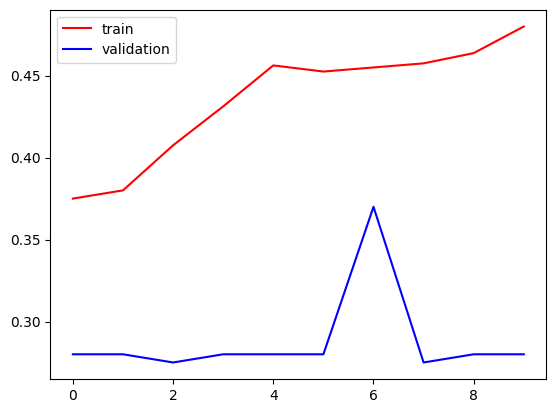

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

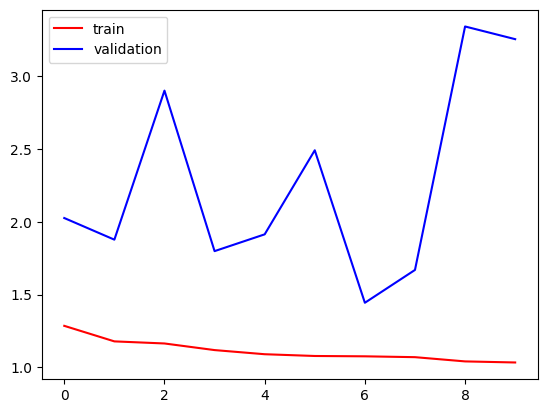

In [21]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()